In [3]:
# Импорт основных библиотек
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

# Библиотека для обработки языка
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Библиотека для машинного обучения (векторизация, модели и метрики классификации, GridSearch)
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Библиотека для (де)сериализации моделей
import pickle 

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Объединение файлов с отзывами
def merge_files(path, label):
    result = []
    files = [f for f in os.listdir(path)]
    for file in files:
        with open(path+file, "r", encoding='utf8') as f:
            review_id = int(' '.join(re.findall(r'([\d]+)_', file)))
            review_rate = ' '.join(re.findall(r'_([\d]+).', file))
            result.append([review_id, f.read(), review_rate, label])
    return result

In [5]:
pos_train_files = merge_files('C:/aclImdb/train/pos/', 1)
neg_train_files = merge_files('C:/aclImdb/train/neg/', 0)

pos_test_files = merge_files('C:/aclImdb/test/pos/', 1)
neg_test_files = merge_files('C:/aclImdb/test/neg/', 0)

In [6]:
# Формирование датафреймов
df_train_pos = pd.DataFrame(pos_train_files, columns=['index', 'text', 'rate', 'label'])
df_train_pos.set_index('index', inplace=True)
df_train_neg = pd.DataFrame(neg_train_files, columns=['index', 'text', 'rate', 'label'])
df_train_neg.set_index('index', inplace=True)

df_test_pos = pd.DataFrame(pos_test_files, columns=['index', 'text', 'rate', 'label'])
df_test_pos.set_index('index', inplace=True)
df_test_neg = pd.DataFrame(neg_test_files, columns=['index', 'text', 'rate', 'label'])
df_test_neg.set_index('index', inplace=True)

In [7]:
# Добавление ссылок на фильмы
urls_train_pos = pd.read_csv('C:/aclImdb/train/urls_pos.txt', header=None, names=['link'])
urls_train_neg = pd.read_csv('C:/aclImdb/train/urls_neg.txt', header=None, names=['link'])
urls_test_pos = pd.read_csv('C:/aclImdb/test/urls_pos.txt', header=None, names=['link'])
urls_test_neg = pd.read_csv('C:/aclImdb/test/urls_neg.txt', header=None, names=['link'])

df_train_pos = df_train_pos.join(urls_train_pos)
df_train_neg = df_train_neg.join(urls_train_neg)
df_test_pos = df_test_pos.join(urls_test_pos)
df_test_neg = df_test_neg.join(urls_test_neg)

In [8]:
# Объединение отзывов в обучающий и тестовый датафреймы
df_train = pd.concat([df_train_pos, df_train_neg], ignore_index=True)
df_test = pd.concat([df_test_pos, df_test_neg], ignore_index=True)

In [9]:
df_train['rate'] = df_train['rate'].astype(int)
df_test['rate'] = df_test['rate'].astype(int)

In [10]:
df_train.head()

,text,rate,label,link
0,Bromwell High is a cartoon comedy. It ran at t...,9,1,http://www.imdb.com/title/tt0453418/usercomments
1,Homelessness (or Houselessness as George Carli...,8,1,http://www.imdb.com/title/tt0102303/usercomments
2,Brilliant over-acting by Lesley Ann Warren. Be...,10,1,http://www.imdb.com/title/tt0102303/usercomments
3,This is easily the most underrated film inn th...,7,1,http://www.imdb.com/title/tt0102303/usercomments
4,This is not the typical Mel Brooks film. It wa...,8,1,http://www.imdb.com/title/tt0102303/usercomments


In [11]:
# Нулевые элементы
df_train.isnull().sum()

text     0
rate     0
label    0
link     0
dtype: int64

In [12]:
print('Размер обучающей выборки: ', len(df_train))
print('Количество уникальных фильмов: ', len(df_train['link'].unique()))
print('Возможные оценки: ', sorted(df_train['rate'].unique()))

Размер обучающей выборки:  25000
Количество уникальных фильмов:  3456
Возможные оценки:  [1, 2, 3, 4, 7, 8, 9, 10]


In [13]:
print('Пример отзыва: ', df_train.text[1])

Пример отзыва:  Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school, work, or vote for the matter. Most people think of the homeless as just a lost cause while worrying about things such as racism, the war on Iraq, pressuring kids to succeed, technology, the elections, inflation, or worrying if they'll be next to end up on the streets.<br /><br />But what if you were given a bet to live on the streets for a month without the luxuries you once had from a home, the entertainment sets, a bathroom, pictures on the wall, a computer, and everything you once treasure to see what it's like to be homeless? That is Goddard Bolt's lesson.<br /><br />Mel Brooks (who directs) who stars as Bolt plays a rich man who has everything in the world until deciding to make a bet with a sissy rival (Jeffery Tambor) to see if he can live in the streets for thirty

In [14]:
df_train['rate'].value_counts()

1     5100
10    4732
8     3009
4     2696
7     2496
3     2420
2     2284
9     2263
Name: rate, dtype: int64

In [15]:
# Анализ длины отзывов в символах
df_train['text'].str.len().describe()

count    25000.00000
mean      1325.06964
std       1003.13367
min         52.00000
25%        702.00000
50%        979.00000
75%       1614.00000
max      13704.00000
Name: text, dtype: float64

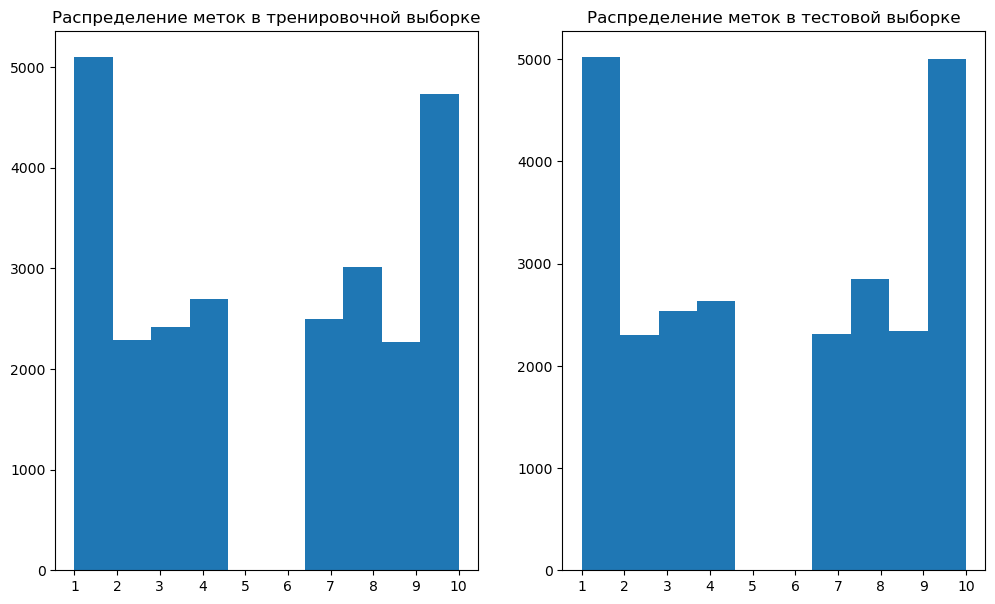

In [16]:
# Распределение меток классов в выборках
plt.figure(figsize=(12, 7))

plt.subplot(1, 2, 1)
plt.hist(df_train['rate'])
plt.title('Распределение меток в тренировочной выборке')
plt.xticks(np.arange(1,11))

plt.subplot(1, 2, 2)
plt.hist(df_test['rate'])
plt.title('Распределение меток в тестовой выборке')
plt.xticks(np.arange(1,11))

plt.show()

In [17]:
#Балансировка классов
df_train_und = df_train.groupby('rate', as_index=False).apply(lambda array: array.loc[np.random.choice(array.index, 
                                                                                                       2263, False),:])

In [18]:
# Функция для предобработки текста - удаление тегов и лишних символов
def text_preprocessor(text):
    text = re.sub(re.compile('<.*?>'), '', text)
    text =  re.sub('[^A-Za-z0-9]+', ' ', text)
    return text.lower()


# Функция лемматизации
def text_lemmatizer(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    return [lemmatizer.lemmatize(t) for t in tokens]

In [19]:
# Векторизация
vectorizer =  TfidfVectorizer(tokenizer=text_lemmatizer, preprocessor=text_preprocessor,
                              ngram_range=(1,3), min_df=5, max_df=95)

X_train = vectorizer.fit_transform(df_train_und['text'].tolist())
y_train = np.array(df_train_und['rate'].tolist(), dtype=np.int64)

X_test = vectorizer.transform(df_test['text'].tolist())
y_test = np.array(df_test['rate'].tolist(), dtype=np.int64)

Далее на обработанной тренировочной выборке обучаются модели LinearSVC, LogisticRegression, RandomForestClassifier с предварительным подбором гиперпараметров

In [20]:
# Подбор гиперпараметров LinearSVC
#parameters_svc = {'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'], 'loss': ['hinge', 'squared_hinge'],
#              'multi_class': ['ovr', 'crammer_singer']}
#grid_svc = GridSearchCV(LinearSVC(), parameters_svc, cv=5)
#grid_svc.fit(X_train, y_train)
#print("Best cross-validation score: {:.2f}".format(grid.best_score_))
#print("Best parameters: ", grid.best_params_)
#print("Best estimator: ", grid.best_estimator_)

In [38]:
# LinearSVC
classifier_svc =  LinearSVC(C=0.1, random_state=12345)

classifier_svc.fit(X_train, y_train)

y_pred_train = classifier_svc.predict(X_train)
y_pred_test = classifier_svc.predict(X_test)
y_pred_test_class = np.around(y_pred_test)

              precision    recall  f1-score   support

           1       0.59      0.64      0.61      5022
           2       0.21      0.23      0.22      2302
           3       0.27      0.26      0.27      2541
           4       0.30      0.30      0.30      2635
           7       0.30      0.29      0.29      2307
           8       0.28      0.22      0.25      2850
           9       0.22      0.27      0.24      2344
          10       0.55      0.50      0.52      4999

    accuracy                           0.39     25000
   macro avg       0.34      0.34      0.34     25000
weighted avg       0.39      0.39      0.39     25000



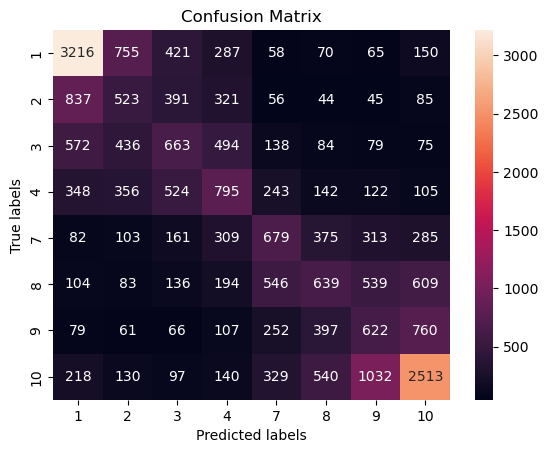

In [39]:
# Отчет об ошибках LinearSVC
report_svc = classification_report(y_test.astype('int'), y_pred_test_class.astype('int'), labels=[1,2,3,4,7,8,9,10])
print(report_svc)

cm_svc = confusion_matrix(y_test.astype('int'), y_pred_test_class.astype('int'), labels=[1,2,3,4,7,8,9,10])

ax = plt.subplot()
sns.heatmap(cm_svc, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels([1,2,3,4,7,8,9,10])
ax.yaxis.set_ticklabels([1,2,3,4,7,8,9,10])
plt.show()

In [40]:
# Подбор гиперпараметров LogisticRegression()
#parameters_logreg = {'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2', 'elasticnet'],  
#              'multi_class': ['ovr', 'crammer_singer'], 
#              'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}
#grid_logreg = GridSearchCV(LogisticRegression(), parameters_logreg, cv=5, verbose=10)
#grid_logreg.fit(X_train, y_train)

In [41]:
#print("Best cross-validation score: {:.2f}".format(grid_logreg.best_score_))
#print("Best parameters: ", grid_logreg.best_params_)
#print("Best estimator: ", grid_logreg.best_estimator_)

In [42]:
# LogisticRegression()
classifier_logreg = LogisticRegression(C=1, multi_class='ovr', random_state=12345)
classifier_logreg.fit(X_train, y_train)

y_pred_train = classifier_logreg.predict(X_train)
y_pred_test = classifier_logreg.predict(X_test)
y_pred_test_class = np.around(y_pred_test)

              precision    recall  f1-score   support

           1       0.61      0.60      0.61      5022
           2       0.21      0.24      0.23      2302
           3       0.26      0.27      0.27      2541
           4       0.30      0.32      0.31      2635
           7       0.30      0.30      0.30      2307
           8       0.28      0.23      0.25      2850
           9       0.22      0.27      0.24      2344
          10       0.56      0.49      0.52      4999

    accuracy                           0.38     25000
   macro avg       0.34      0.34      0.34     25000
weighted avg       0.39      0.38      0.39     25000



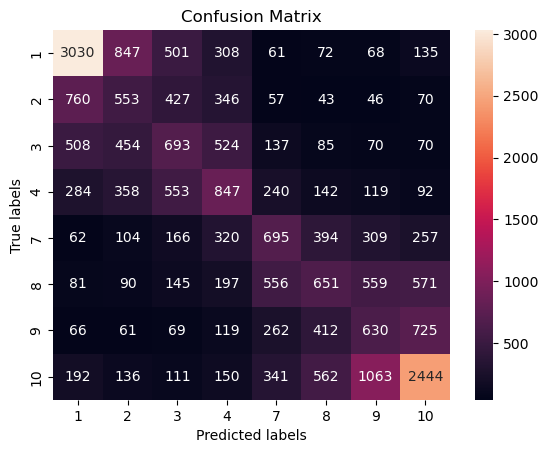

In [43]:
# Отчет об ошибках LogisticRegression()
report_logreg = classification_report(y_test.astype('int'), y_pred_test_class.astype('int'), labels=[1,2,3,4,7,8,9,10])
print(report_logreg)

cm_logreg = confusion_matrix(y_test.astype('int'), y_pred_test_class.astype('int'), labels=[1,2,3,4,7,8,9,10])

ax = plt.subplot()
sns.heatmap(cm_logreg, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels([1,2,3,4,7,8,9,10])
ax.yaxis.set_ticklabels([1,2,3,4,7,8,9,10])
plt.show()

In [28]:
# Подбор гиперпараметров RandomForestClassifier()
#parameters_rforest = {'n_estimators': [400, 500, 600], 
#              'max_depth': [20, 30, 40],  
#              'criterion': ['log_loss']}
#grid_rforest = GridSearchCV(RandomForestClassifier(), parameters_rforest, cv=5, verbose=10)
#grid_rforest.fit(X_train, y_train)
#print("Best cross-validation score: {:.2f}".format(grid_rforest.best_score_))
#print("Best parameters: ", grid_rforest.best_params_)
#print("Best estimator: ", grid_rforest.best_estimator_)

In [29]:
# RandomForestClassifier()
classifier_rforest = RandomForestClassifier(criterion='log_loss', max_depth=30, n_estimators=600)
classifier_rforest.fit(X_train, y_train)

y_pred_train = classifier_rforest.predict(X_train)
y_pred_test = classifier_rforest.predict(X_test)
y_pred_test_class = np.around(y_pred_test)

              precision    recall  f1-score   support

           1       0.54      0.63      0.58      5022
           2       0.22      0.17      0.19      2302
           3       0.28      0.21      0.24      2541
           4       0.29      0.23      0.25      2635
           7       0.24      0.33      0.28      2307
           8       0.23      0.25      0.24      2850
           9       0.21      0.24      0.22      2344
          10       0.49      0.44      0.46      4999

    accuracy                           0.35     25000
   macro avg       0.31      0.31      0.31     25000
weighted avg       0.35      0.35      0.35     25000



[Text(0, 0.5, '1'),
 Text(0, 1.5, '2'),
 Text(0, 2.5, '3'),
 Text(0, 3.5, '4'),
 Text(0, 4.5, '7'),
 Text(0, 5.5, '8'),
 Text(0, 6.5, '9'),
 Text(0, 7.5, '10')]

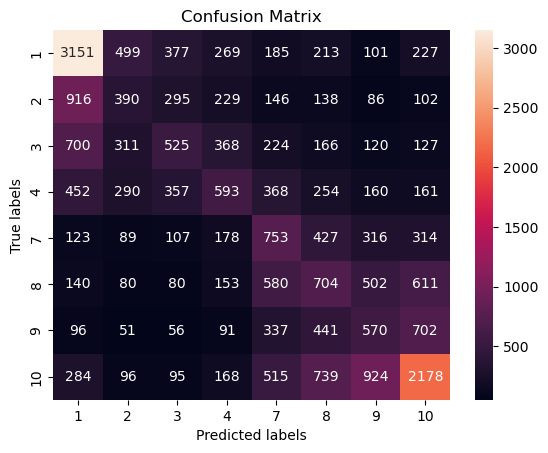

In [30]:
# Отчет об ошибках RandomForestClassifier()
report_rforest = classification_report(y_test.astype('int'), y_pred_test_class.astype('int'), labels=[1,2,3,4,7,8,9,10])
print(report_rforest)

cm_rforest = confusion_matrix(y_test.astype('int'), y_pred_test_class.astype('int'), labels=[1,2,3,4,7,8,9,10])

ax = plt.subplot()
sns.heatmap(cm_rforest, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels([1,2,3,4,7,8,9,10])
ax.yaxis.set_ticklabels([1,2,3,4,7,8,9,10])

In [48]:
# Запись векторизатора и лучшей модели в файл
vectorizer_filename = "./models/vectorizer.pkl" 
with open(vectorizer_filename, 'wb') as file: 
    pickle.dump(vectorizer, file) 
    
model_filename = "./models/model.pkl" 
with open(model_filename, 'wb') as file: 
    pickle.dump(classifier_svc, file) 

with open(vectorizer_filename, 'rb') as file: 
    pickle_vectorizer = pickle.load(file) 

with open(model_filename, 'rb') as file: 
    pickle_model = pickle.load(file) 

In [32]:
#txt = ['''This movie was sadly under-promoted but proved to be truly exceptional. 
#      Entering the theatre I knew nothing about the film except that a friend wanted to see it.<br /><br />
#      I was caught off guard with the high quality of the film. I couldn't image Ashton Kutcher in a serious role, 
#       but his performance truly exemplified his character. This movie is exceptional and deserves our monetary support,
#       unlike so many other movies. It does not come lightly for me to recommend any movie, but in this case I highly 
#       recommend that everyone see it.<br /><br />This films is Truly Exceptional!''']
#x_pred = pickle_vectorizer.transform(txt)
#pickle_model.predict(x_pred)

array([9], dtype=int64)

In [46]:
import os

current_dir = os.getcwd()
print(current_dir)

C:\Users\Арсений\PycharmProjects\sentiment_analysis_test
